# Particles

In [2]:
def ls(path="/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):
    print(subprocess.check_output("ls -ht " + path, shell=True).decode('ascii').strip())

In [3]:
def get_simulation_output(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/",file_name="htcondor*.out", print_1=True, n=0):
    file_content = subprocess.check_output("cat " + path + folder + f'/Job.{n}/' + file_name, shell=True).decode('ascii').strip()
    if print_1:
        print(file_content)
    else:
        return file_content

def get_analysis_init(folder, suffix , path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", file_name="htcondor*.out", n=0):
    file_lines = get_simulation_output(folder, print_1=False, path = path, n=n).split('\n')
    for i in range(len(file_lines)):
        if 'CrystalAnalysis' in file_lines[i] or 'TargetAnalysis' in file_lines[i]:
            if file_lines[i-1] in ['TCCS', 'TCCP', 'TARGET', 'PIXEL', 'TCP']:
                print(file_lines[i-1]+suffix+' = '+file_lines[i])
            else:    
                print('OBJ'+suffix+' = '+file_lines[i])

In [4]:
def check_config(folder, path="/afs/cern.ch/work/c/cmaccani/xsuite_sim/twocryst_sim/Condor/", cat=['run']):
    with open(path + folder + '/input_cache/config_sim.yaml', 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    for c in cat:
        print(config[c])

In [5]:
def turn_plots(TCCS, TARGET, n_turn):

    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part

    df_TCCS = df_TCCS[df_TCCS['this_turn']==n_turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==n_turn]


    print("IMPACT ON TCCS AT TURN ", n_turn)    
    TCCS.plot_distributions(df_TCCS['x'], df_TCCS['y'], df_TCCS['px'], df_TCCS['py'], xpcrit=True)
    print("IMPACT ON TARGET AT TURN ", n_turn)    
    TARGET.plot_distributions(df_TARGET['x'], df_TARGET['y'], df_TARGET['px'], df_TARGET['py'])

    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]
   
    print('TCCS impacts: ', len(df_TCCS), '\ninside critical angle:', len(channable)  ,'\nTARGET impacts' ,len(df_TARGET), '\nCommon impacts: ', len(common_ids))

    df_common = df_TCCS[df_TCCS['particle_id'].isin(common_ids)]
    print("\nIMPACTS ON TARGET FROM TCCS AT TURN ", n_turn)    
    TCCS.plot_distributions(df_common['x'], df_common['y'], df_common['px'], df_common['py'], xpcrit=True)

In [6]:
def plot_turns(TCCS, TARGET, turns=200):
    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part
    tccs, target, channable, common = [], [], [], []
    x = np.arange(turns)
    for t in range(turns):
        tccs.append(len(df_TCCS[df_TCCS['this_turn']==t]))
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))
        tmp_TCCS = df_TCCS[df_TCCS['this_turn']==t]
        tmp_target = df_TARGET[df_TARGET['this_turn']==t]
        common_ids = np.intersect1d(tmp_TCCS['particle_id'], tmp_target['particle_id'])
        channable.append(len(tmp_TCCS[(tmp_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (tmp_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]))
        common.append(len(tmp_TCCS[tmp_TCCS['particle_id'].isin(common_ids)]))

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, tccs, label='TCCS impacts')
    ax.plot(x, target, label='TARGET impacts')
    ax.plot(x, channable, label='TCCS impacts inside critical angle')
    ax.plot(x, common, label='Common impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target))

In [6]:
def get_bad_particles(TCCS, TARGET, TCP, turn=0):

    def print_part(df):
        if len(df) == 0:
            print('No data')
            return
        print('x = ', df['x'].iloc[0])
        print('y = ', df['y'].iloc[0])
        print('px = ', df['px'].iloc[0])
        print('py = ', df['py'].iloc[0])
        print('zeta = ', df['zeta'].iloc[0])
        print('delta = ', df['delta'].iloc[0])


    df_TCCS = TCCS.data
    df_TARGET = TARGET.impact_part
    df_TCP = TCP.data

    df_TCCS = df_TCCS[df_TCCS['this_turn']==turn]
    df_TARGET = df_TARGET[df_TARGET['this_turn']==turn]
    common_ids = np.intersect1d(df_TCCS['particle_id'], df_TARGET['particle_id'])

    channable = df_TCCS[(df_TCCS['py'] > TCCS.align_angle - np.abs(TCCS.xp_crit)) & (df_TCCS['py'] < TCCS.align_angle  + np.abs(TCCS.xp_crit))]
    df_common = df_TARGET[~df_TARGET['particle_id'].isin(common_ids)]

    id = df_common['particle_id'].iloc[0]
    print('ID: ', id)

    particle_tccs = df_TCCS[df_TCCS['particle_id']==id]
    print_part(particle_tccs)
    print('\n TARGET')    
    particle_target = df_TARGET[df_TARGET['particle_id']==id]
    print_part(particle_target)
    print('\nTCP')   
    particle_tcp = df_TCP[df_TCP['particle_id']==id]
    print_part(particle_tcp)
    print('\n')  


    return particle_tccs

In [23]:
def plot_two_targets_impacts(TARGET0, TARGET1, turns=200):
    df_TARGET0 = TARGET0.impact_part
    df_TARGET1 = TARGET1.impact_part
    target0, target1 = [], []
    x = np.arange(turns)
    for t in range(turns):
        target0.append(len(df_TARGET0[df_TARGET0['this_turn']==t]))
        target1.append(len(df_TARGET1[df_TARGET1['this_turn']==t]))
        

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(x, target0, label='TARGET 0 impacts')
    ax.plot(x, target1, label='TARGET 1 impacts')
    #ax.set_yscale('log')
    ax.legend()
    print(np.argmax(target0), np.argmax(target1))


def calculate_target_impacts_threshold(TARGET, threshold , turns=200):
    df_TARGET = TARGET.impact_part
    target = []
    x = np.arange(turns)
    for t in range(turns):
        target.append(len(df_TARGET[df_TARGET['this_turn']==t]))

    print('thershold: ', threshold, 'before thershold: ', np.sum(target[:threshold]), f"{  (np.sum(target[:threshold])/np.sum(target)*100):.{1}f}% \t after thershold: ", np.sum(target[threshold:]), f"   {(np.sum(target[threshold:])/np.sum(target)*100):.{1}f}%")

13 13


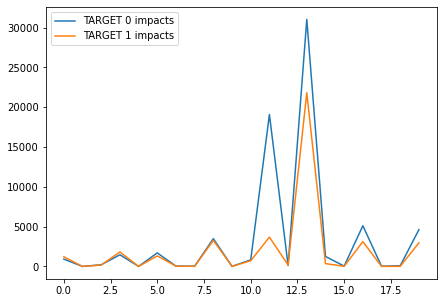

In [49]:
plot_two_targets_impacts(TARGET_tune, TARGET_phase, turns=20)


In [118]:
calculate_target_impacts_threshold(TARGET_tune, 60)
calculate_target_impacts_threshold(TARGET_phase, 60)

thershold:  60 before thershold:  117624 90.6% 	 after thershold:  12184    9.4%
thershold:  60 before thershold:  73831 89.4% 	 after thershold:  8772    10.6%


In [25]:
len(TARGET_tune.impact_part)


  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')



IndentationError: unexpected indent (4286522241.py, line 4)

In [1]:
tau = 200*60*60
tau_BO = 20*60*60
I0 = 2.8e14

t = 60*60*10 

part = len(TARGET_tune.impact_part)

N_sim = TARGET_tune.n_jobs*TARGET_tune.part_per_job

c_exp = 1/tau + 1/tau_BO
C = I0 / (2*tau) * part  / N_sim
POT = C/c_exp * (1 - np.exp(-c_exp*t))

print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')

NameError: name 'TARGET_tune' is not defined

In [8]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy
from scipy.optimize import curve_fit


class ParticleAnalysis():

    def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V'):

        self.beam = beam
        self.plane = plane
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.sigma = sigma
        self.jaw_L = sigma * n_sigma
        self.p0c = None
        self.npart = None
        self.data = None
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2

        self.impact_part = None
        self.fit = None

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None

        self.coll_names = {'TCCS': 'tccs.5r3.b2', 'TCCP': 'tccp.4l3.b2', 'TARGET': 'target.4l3.b2', 'TCLA': 'tcla.a5l3.b2'}
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        return path_list   
    
    

    def load_particles(self, path, df_key, Condor=True, 
                       file_name='particle*.h5', 
                       default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                       part_per_job = 100000):
                
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name)
            self.n_jobs = len(h5_file_path)
        else:
            h5_file_path = (subprocess.check_output("echo " + default_path + path +file_name, shell=True)).decode('ascii').strip()

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        i = 0 
        for file in h5_file_path:
            try:
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + part_per_job*i    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + part_per_job*i
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
            i = i + 1
                       
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c

        hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
        self.impact_part = self.data[hit_mask]
    


    def plot_rectangle(self, ax, x_low, x_up, y_low, y_up):
        rect = patches.Rectangle((x_low, y_low), x_up - x_low, y_up - y_low, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)


    def plot_xy_distribution(self, fig, ax, x, y):

        h = ax.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax.set_xlabel(r'x [mm]')
        ax.set_ylabel(r'y [mm]')
        ax.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax_tw = ax.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax_tw.set_ylim(ax.get_ylim()[0]/sigma_abs, ax.get_ylim()[1]/sigma_abs)
        
        if ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 20 and ax_tw.get_ylim()[0] - ax_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 60 and ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax_tw.get_ylim()[1] - ax_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax_tw.get_ylim()[0]), np.floor(ax_tw.get_ylim()[1]) + 1, n_ticks)
        ax_tw.set_yticks(yticks)
        ax_tw.set_ylabel(r' n $\sigma$')
        
        ax_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
        axins = inset_axes(ax, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax.grid(linestyle=':')


            



    def plot_py_distribution(self, fig, ax, py, fit = None, **kwargs):

        ax.hist(py, bins=100) 
        ax.set_xlabel(r'py [$\mu$rad]')
        ax.set_ylabel('')
        ax.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        if "log" in kwargs and kwargs['log'] == True: 
            ax.set_yscale("log")


    def plot_distributions(self, x, y, px, py, fit = None, **kwargs):
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
        ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
        ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        self.plot_xy_distribution(fig1, ax3, x, y)
        self.plot_rectangle(ax3, self.abs_x_low, self.abs_x_up, self.abs_y_low, self.abs_y_up)
        

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")        
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        self.plot_py_distribution(fig1, ax22, py, **kwargs)


        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        if fit is not None:
           
            def gaussian(x, A, mu, sigma):
                return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
            
            for ax, val in zip([ax1, ax2, ax12, ax22], ['x', 'y', 'px', 'py']):
                xmin, xmax = ax.get_xlim()
                x = np.linspace(xmin, xmax, 100)


                hist_values = [rect.get_height() for rect in ax.patches]
                bin_edges = [rect.get_x() for rect in ax.patches]

                # Calculate the area of the histogram
                bin_widths = np.diff(bin_edges)  
                bin_widths = np.append(bin_widths, 0) 
                hist_area = np.sum(hist_values * bin_widths)  

                tmp_y = gaussian(x, fit.loc[val, 'A'], fit.loc[val, 'mu'], fit.loc[val, 'sigma'])
                funct_area = np.trapz(tmp_y, x=x)

                ax.plot(x, gaussian(x, fit.loc[val, 'A']/funct_area*hist_area, fit.loc[val, 'mu'], fit.loc[val, 'sigma']), 'g', linestyle = '-', linewidth=1)


            ellipse_x= patches.Ellipse((fit.loc['x', 'mu'], fit.loc['y', 'mu']), width=3*fit.loc['x', 'sigma'], height=3*fit.loc['y', 'sigma'],fill=False, color = 'g')
            ax3.add_patch(ellipse_x)    
            ax3.set_aspect('equal')

            ellipse_p= patches.Ellipse((fit.loc['px', 'mu'], fit.loc['py', 'mu']), width=3*fit.loc['px', 'sigma'], height=3*fit.loc['py', 'sigma'],fill=False, color = 'g')
            ax32.add_patch(ellipse_p)    
            ax32.set_aspect('equal')

        plt.show()
        
        
    def fit_gaussian(self, impacts = None, plot = True):

        if impacts is None:
            impacts = self.impact_part
            
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-(x - mu)**2 / (2 * sigma**2))
        

        def fit(data, ax = None, plot = True):

            hist, bins = np.histogram(data, bins=100)
            bin_centers = (bins[:-1] + bins[1:]) / 2
            initial_guess = [np.max(hist), np.mean(data), np.std(data)]
            popt, pcov = curve_fit(gaussian, bin_centers, hist, p0=initial_guess)

            if plot:
                ax.bar(bin_centers, hist, width=np.diff(bins), edgecolor='k', align='center', label='Histogram')
                x_fit = np.linspace(min(bin_centers), max(bin_centers), 100)
                ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')
            return popt

        if plot:
            fig1 = plt.figure(figsize=(15, 8))
        df_gauss = pd.DataFrame(columns=[ 'mu', 'sigma'])
        for idx, val in enumerate(['x', 'y', 'px', 'py']):
            ax = None
            if plot:
                ax = fig1.add_subplot(2, 2, idx+1)            
            popt = fit(impacts[val], ax, plot = plot)
            df_gauss = pd.concat([df_gauss, pd.DataFrame({'A':[popt[0]] , 'mu': [popt[1]], 'sigma': [popt[2]]}, index=[val])])
            if plot:
                ax.set_xlabel(val)
                ax.legend()
            
        self.fit = df_gauss



    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, fit = False, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
      
        fit_param = None
        if fit:
            if self.fit is None:
                self.fit_gaussian(plot=False)
            fit_param = self.fit
        self.plot_distributions(self.data['x'], self.data['y'], self.data['px'], self.data['py'], sigma=sigma, log=log, xpcrit=xpcrit, fit = fit_param)

    def plot_phasespace(self, **kwargs):

        fig1 = plt.figure(figsize=(18, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax2 = fig1.add_subplot(1,2,2)

        
        
        #ax1.scatter(self.data['x'], self.data['px'])
        #ax2.scatter(self.data['y'], self.data['py'])
        h1 = ax1.hist2d(self.data['x'], self.data['px'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax1.set_xlabel(r'x [m]')
        ax1.set_ylabel(r'px [rad]')
        axins = inset_axes(ax1, height="100%",  width="5%", loc='right', borderpad=-3)
        fig1.colorbar(h1[3], cax=axins, orientation='vertical')
        ax1.grid(linestyle=':')
        #ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax1.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])


        h2 = ax2.hist2d(self.data['y'], self.data['py'], bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax2.set_xlabel(r'y[m]')
        ax2.set_ylabel(r'py [rad]')
        axins2 = inset_axes(ax2, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins2, orientation='vertical', label='Count (log scale)')
        ax2.grid(linestyle=':')
        #ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        #ax2.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/Run3_flat_top/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.coll_names['TCLA']: 1.0, self.coll_names['TCCS']: 0.004, self.coll_names['TCCP']: 0.07, self.coll_names['TARGET']: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df

    def save_particle_data(self,  file_name = None, output_path='./', key = 'particles'):
        if file_name is None:
            file_name = f'particles_B{self.beam}{self.plane}.h5'    
        self.data.to_hdf(output_path + file_name, key = key, mode='w', format='table', complevel=9, complib='blosc')





# ---------------------------------------------------  CRYSTAL   ---------------------------------------------------



class CrystalAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, bending_radius=None, align_angle = None,
                beam = 2, plane = 'V',
                pot_crit = 21.34, #16 #eV Silicon
                en_crit = 5.7e9 / 1e-2 #eV/m Silicon    #dp_Si = 1.92e-10 #m
                ):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, beam = beam, plane = plane, sigma = sigma)
    
    self.align_angle = align_angle
    self.en_crit = en_crit
    self.pot_crit = pot_crit
    self.bending_radius = bending_radius 


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)


    """ai = 0.96e-7
    eUm = 21.34
    xp_crit0 = np.sqrt((2.0e-9*eUm)/self.p0c)
    Rcrit   = (self.p0c/(2.0e-6*eUm))*ai"""

  
    
    xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
    Rcrit = self.p0c/self.en_crit
    
    #print(f'xp_crit0: {xp_crit0}, Rcrit: {Rcrit}')

    self.xp_crit = xp_crit0*(1-Rcrit/self.bending_radius)
    if(self.xp_crit < 0):
          print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bending_radius} m \n!!!!!!!!!!!!!")
    

  def plot_py_distribution(self, fig, ax, py, print=True, **kwargs):
        
        super().plot_py_distribution(fig, ax, py, **kwargs)

        if "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            new_align_angle = None
            if "align_angle" in kwargs:
                new_align_angle = kwargs['align_angle']
            elif self.align_angle is not None:
                new_align_angle = self.align_angle
             
            if new_align_angle is not None: 
                ax.axvline(new_align_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bending_radius} \n!!!!!!!!!!!!!")
                else:
                    ax.axvline(new_align_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax.axvline(new_align_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > new_align_angle  - np.abs(self.xp_crit)) & (py < new_align_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    if print:
                        ax.set_title(f'N particle inside critical angle range: {chann}')






  def compute_channeled_part(self, impacts):

    channable_ids = self.data[(self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]['particle_id']
    chann_num = len(np.intersect1d(channable_ids, impacts['particle_id']))
    print('n particles that hit TCCP inside critical angle range: \t', chann_num)
    print('n part inside critical angle range: \t\t\t', len(channable_ids), f'\t\t{chann_num/len(channable_ids)*100:.2f}%' )
    print('n part that hit TCCS (multiple):\t\t\t', self.npart, f'\t{chann_num/self.npart*100:.2f}%')
    print('n part that hit TCCP: \t\t\t\t\t', len(impacts), f'\t\t{chann_num/len(impacts)*100:.2f}%' )
    if self.n_jobs is not None:
        print(f'total n particle in simulation: \t\t\t {self.n_jobs*self.part_per_job:.1e}\t{chann_num/(self.n_jobs*self.part_per_job)*100:.2f}%')


  def optimize_alignment(self):

    data = self.data[['py', 'at_element']]
    min_py = data['py'].min()
    max_py = 0 # data['py'].max()
    
    n_steps = 1000
    x = np.linspace(min_py + self.xp_crit, max_py - self.xp_crit, n_steps)
    y = []
    for i in range(n_steps):
        mask = (data['py'] > x[i] - self.xp_crit) & (data['py'] < x[i] + self.xp_crit)
        y.append(len(data['py'][mask]))

    best_angle = x[y.index(max(y))]

    fig1 = plt.figure(figsize=(15, 5))
    ax1 = fig1.add_subplot(1,2,1)
    ax1.plot(x, y)
    ax1.set_xlabel('angle [rad]')
    ax1.set_ylabel("n_part")
    ax1.axvline(best_angle, color = 'g', linestyle = '-')
    ax1.axvline(self.align_angle, color = 'r', linestyle = '-')

    ax2 = fig1.add_subplot(1,2,2)
    self.plot_py_distribution(fig1, ax2, data['py'], xpcrit=True, align_angle = best_angle, print=False)

    chann_mask = (data['py'] > self.align_angle  - np.abs(self.xp_crit)) & (data['py'] < self.align_angle  + np.abs(self.xp_crit))
    chann = len(data['py'][chann_mask])

    fig1.suptitle(f'Optimal angle {best_angle:.3e},  {max(y)} particles \nAlignment angle {self.align_angle:.3e}, {chann} particles')

    print(f'Delta angle {best_angle - self.align_angle}')




# ---------------------------------------------------  TARGET   ---------------------------------------------------
    

class TargetAnalysis(ParticleAnalysis):

  def __init__(self, n_sigma, length, xdim, ydim, sigma, beam = 2, plane = 'V'):

    super().__init__(n_sigma = n_sigma, length = length, xdim = xdim, ydim = ydim, sigma = sigma, beam = beam, plane = plane)
    
    


  def load_particles(self, path, df_key = 'particles', Condor=True, 
                      file_name='particle*.h5', 
                      default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/",
                      part_per_job = 100000):
        
    super().load_particles(path, df_key, Condor, file_name, default_path, part_per_job)

    data = self.data['particle_id']
    duplicated_mask = data.duplicated()
    if len(data[duplicated_mask]) != 0:
        print(f'There are repeated particle ids: {data[duplicated_mask]}')

    


  def optimize_POT(self, set = False, mode='fit'):
    
        
        x = self.data['x']
        y = self.data['y']

        abs_x_low = -self.xdim/2
        abs_x_up = self.xdim/2

        nsteps = 100
        steps = np.linspace(self.jaw_L - 3e-3, self.jaw_L + self.ydim, nsteps)
        n_part = []

        for stp in steps:
            abs_y_low = stp
            abs_y_up = stp + self.ydim
            n_part.append(len(x[(x >= abs_x_low) & (x <= abs_x_up) & (y >= abs_y_low) & (y <= abs_y_up)]))
        

        if mode == 'fit':
            if self.fit is None:
                self.fit_gaussian(plot=False)

            best_jawL = self.fit.loc['y', 'mu'] - self.ydim/2
        elif mode == 'max':
            best_jawL = steps[n_part.index(max(n_part))]

        fig1 = plt.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(1,2,1)
        ax1.plot(steps, n_part)
        ax1.set_xlabel('y position [mm]')
        ax1.set_ylabel("n_part")
        ax1.axvline(best_jawL, color = 'g', linestyle = '-')
        ax1.axvline(self.jaw_L, color = 'r', linestyle = '-')

        ax3 = fig1.add_subplot(1,2,2)
        super().plot_xy_distribution(fig1, ax3, x, y)
        super().plot_rectangle(ax3, abs_x_low, abs_x_up, best_jawL, best_jawL + self.ydim)

        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1.suptitle(f'Optimal jaw setting {best_jawL/self.jaw_L*self.n_sigma:.5} $\sigma$, \t{max(n_part)} particles \nSimulation jaw setting {self.n_sigma} $\sigma$, \t{hitting_particles} particles\n ')


        if set:
            new_sigma = best_jawL/self.jaw_L*self.n_sigma
            self.abs_y_low = best_jawL
            self.abs_y_up = best_jawL + self.ydim
            self.n_sigma = new_sigma
            self.jaw_L = best_jawL

            hit_mask = ((self.data['x'] >= self.abs_x_low) & (self.data['x'] <= self.abs_x_up) & (self.data['y'] >= self.abs_y_low) & (self.data['y'] <= self.abs_y_up))
            self.impact_part = self.data[hit_mask]




  def calculate_proton_on_target(self, t, N_sim = None, 
                                 tau = 200*60*60, tau_BO = 20*60*60, I0 = 2.8e14):
    
     
    if N_sim is None and self.n_jobs is not None:
        N_sim = self.n_jobs*self.part_per_job

    c_exp = 1/tau + 1/tau_BO
    C = I0 / (2*tau) * len(self.impact_part) / N_sim
    POT = C/c_exp * (1 - np.exp(-c_exp*t))

    print(f'Protons on target: {POT:.3e} in ', t, 's ==> ', t/(60*60), 'h')
    print(f'Flux: {POT/t:.3e} p/s')




      

No pytransport functionality
No pytransport functionality


In [9]:
ls()

TEST_IR7_tune_double_channeling___20240313-1004
TEST_IR7_tune_very_new_version___20240312-0921
TEST_IR7_tune_very_new_version_as_before_target_absorber_20240312-0920
TEST_IR7_tune_very_new_version__target_absorber_20240312-0919
TEST_IR7_tune_very_new_version_phase__target_absorber_20240312-0919
TEST_prova_no_targ__20240305-1800
TEST_prova__target_absorber_20240305-1759
TEST_IR7rem_TCCS_7.2_tune_scan__-2.0__target_absorber_20240301-1050
TEST_IR7rem_TCCS_7.2_tune_scan__-1.5__target_absorber_20240301-1049
TEST_IR7rem_TCCS_7.2_tune_scan__-1.0__target_absorber_20240301-1048
TEST_IR7rem_TCCS_7.2_tune_scan__-0.5__target_absorber_20240301-1047
TEST_IR7rem_TCCS_7.2_tune_scan__1.0__target_absorber_20240301-1046
TEST_IR7rem_TCCS_7.2_tune_scan__+0.5__target_absorber_20240229-1058
TEST_IR7rem_TCCS_7.2_phadv_v2__target_absorber_20240229-1054
TEST_IR7rem_TCCS_7.2_tune__target_absorber_20240228-1824
TEST_IR7rem_TCCS_7.2__target_absorber_20240228-1035
TEST_IR7rem_phadv_ang_TCCS_7.2__target_absorber_202

# New Simulations

In [10]:
as_before = 'TEST_IR7_tune_very_new_version__target_absorber_20240312-0919'#'TEST_IR7_tune_very_new_version_as_before_target_absorber_20240312-0920'

In [11]:
get_analysis_init(as_before, '_tune')

TCCS_tune = CrystalAnalysis(n_sigma=7.199999999999999, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.4117913840472246e-05, sigma=0.00028108982563020184)
TARGET_tune = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.008, sigma=0.00030717792331422136)
TCCP_tune = CrystalAnalysis(n_sigma=33.6, length=0.07, ydim=0.002, xdim=0.008, bending_radius=10.0, align_angle=0.00011149764371098073, sigma=0.00030719451513353804)
TCP_tune = TargetAnalysis(n_sigma=6.700000000000001, length=0.6, ydim=0.025, xdim=0.025, sigma=0.0003431239177650901)
PIXEL_tune = TargetAnalysis(n_sigma=33.6, length=0, ydim=0.01408, xdim=0.04246, sigma=0.00031074736684138284)


In [12]:
TCCS_tune = CrystalAnalysis(n_sigma=7.199999999999999, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.4117913840472246e-05, sigma=0.00028108982563020184)
TARGET_tune = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.008, sigma=0.00030717792331422136)

In [13]:
TCCS_tune.load_particles(as_before, df_key = 'TCCS_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_IR7_tune_very_new_version__target_absorber_20240312-0919


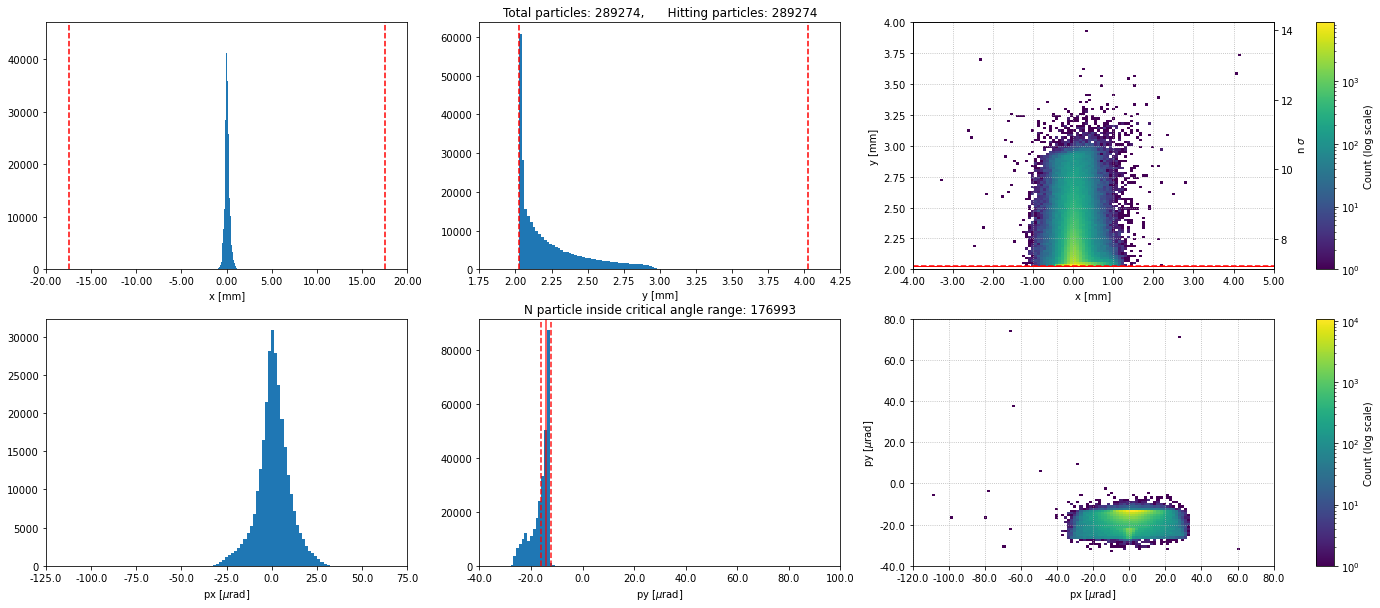

In [14]:
TCCS_tune.compute_impact_particles( xpcrit=True)

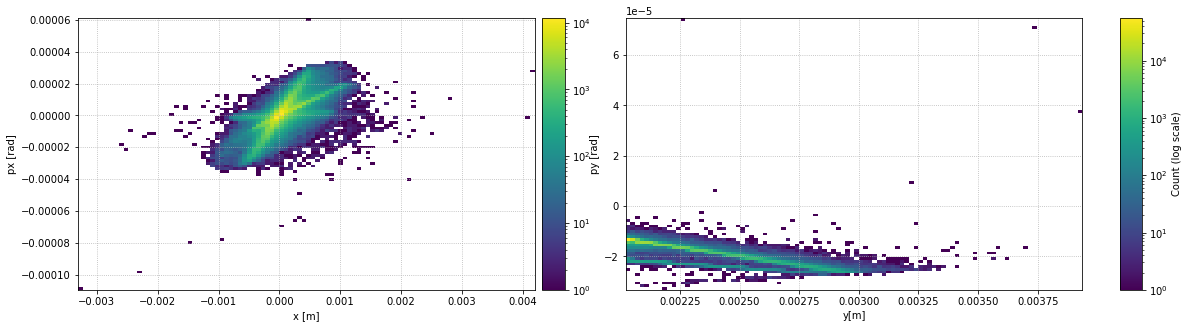

In [15]:
TCCS_tune.plot_phasespace()

In [16]:
TCCS_tune.xp_crit

2.0901894766825708e-06

Delta angle -1.1477939814857822e-06


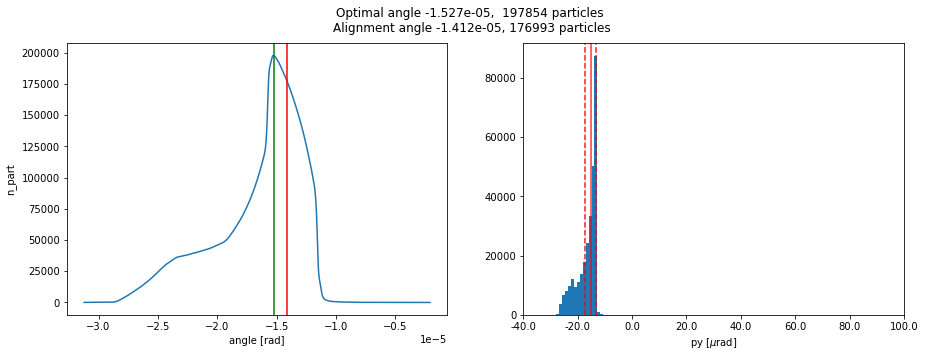

In [17]:
TCCS_tune.optimize_alignment()

In [18]:
TARGET_tune.load_particles(as_before, df_key = 'TARGET_impacts')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_IR7_tune_very_new_version__target_absorber_20240312-0919


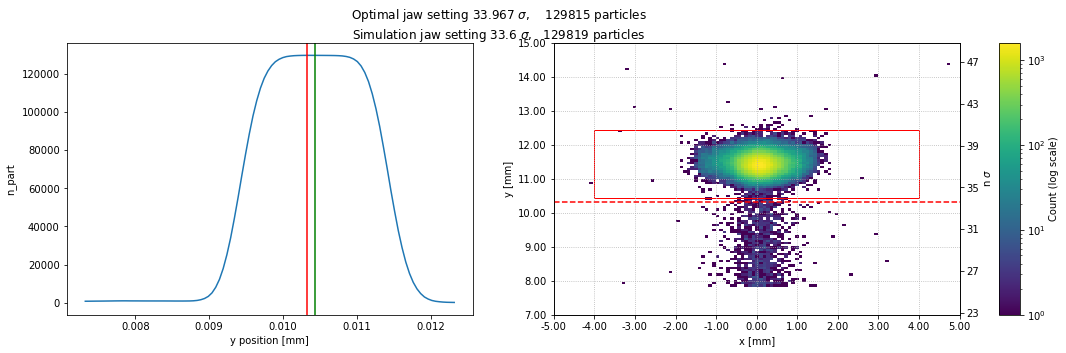

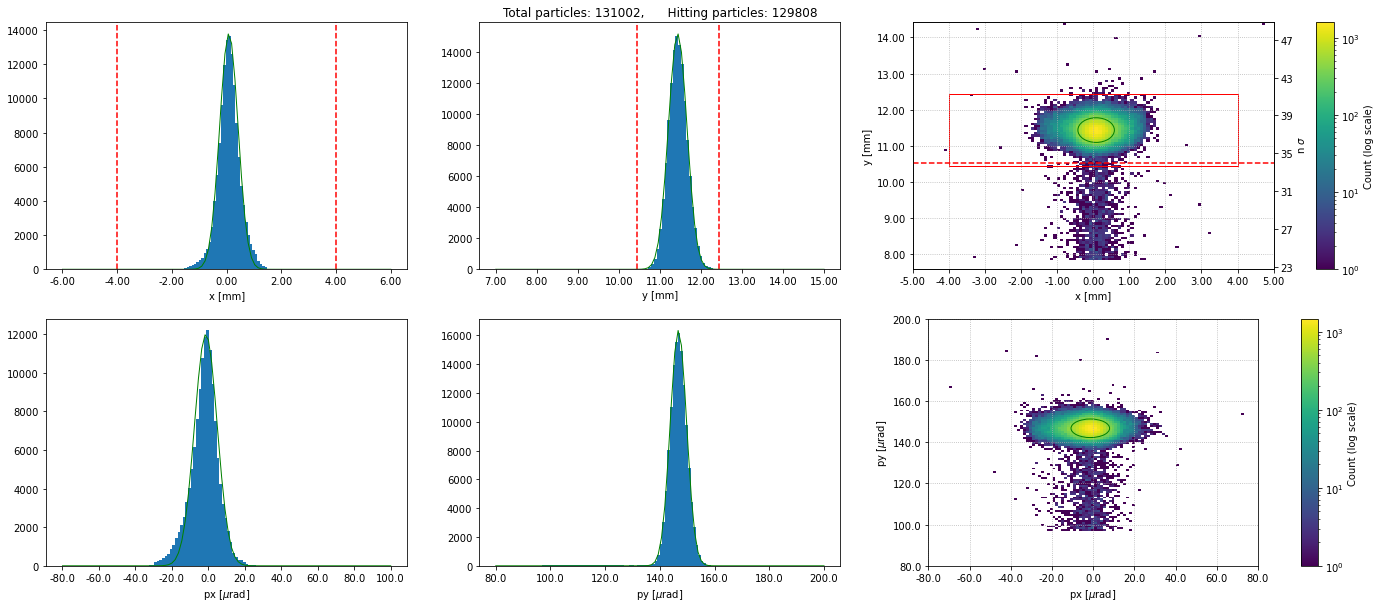

In [19]:
TARGET_tune.optimize_POT(set = True)
TARGET_tune.compute_impact_particles(fit=True)

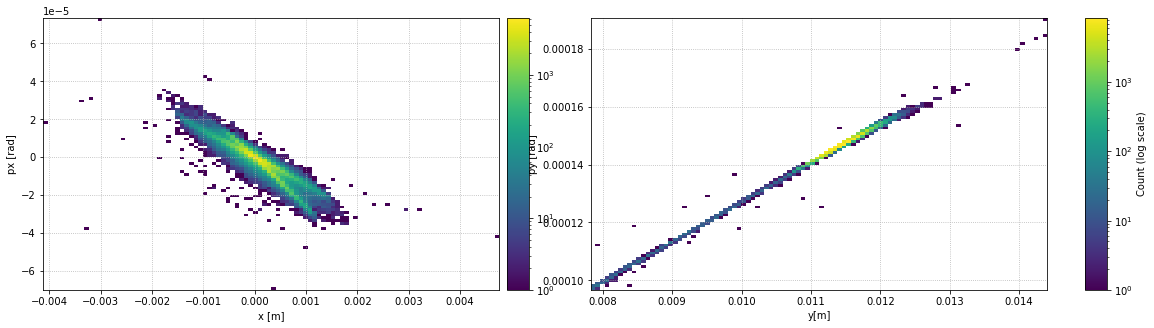

In [20]:
TARGET_tune.plot_phasespace()

In [21]:
TARGET_tune.calculate_proton_on_target(60*60*10)

Protons on target: 7.060e+10 in  36000 s ==>  10.0 h
Flux: 1.961e+06 p/s


In [22]:
turn_plots(TCCS_phase, TARGET_phase, 0)

NameError: name 'TCCS_phase' is not defined

IMPACT ON TCCS AT TURN  0


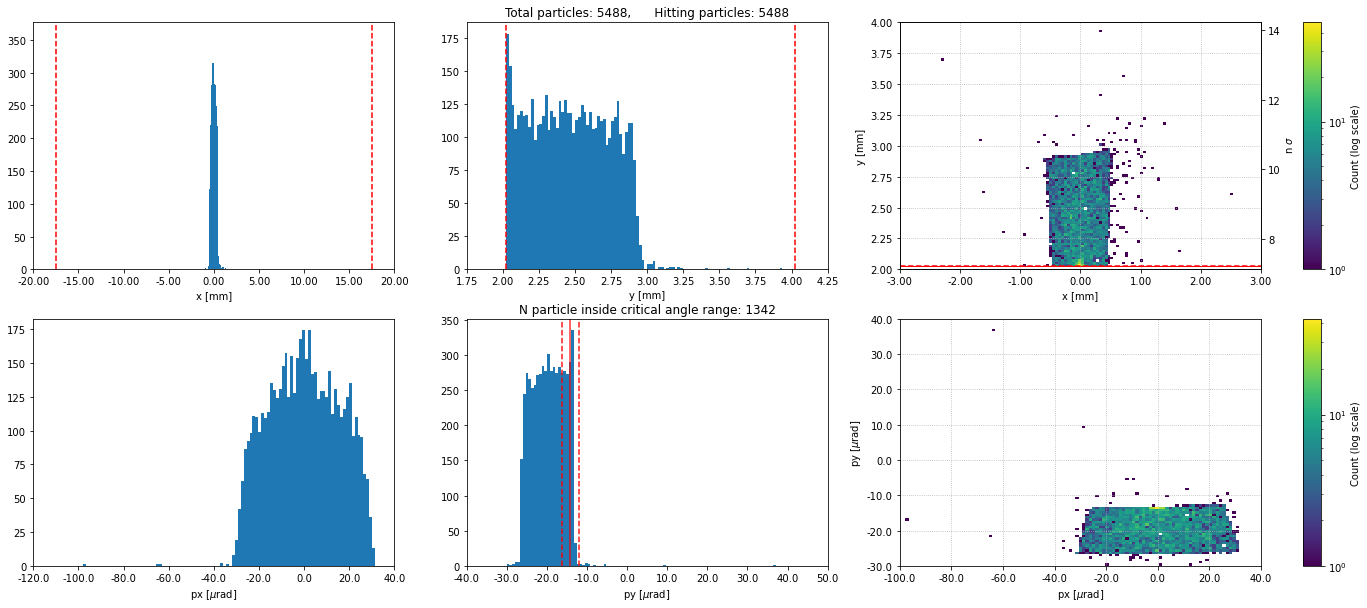

IMPACT ON TARGET AT TURN  0


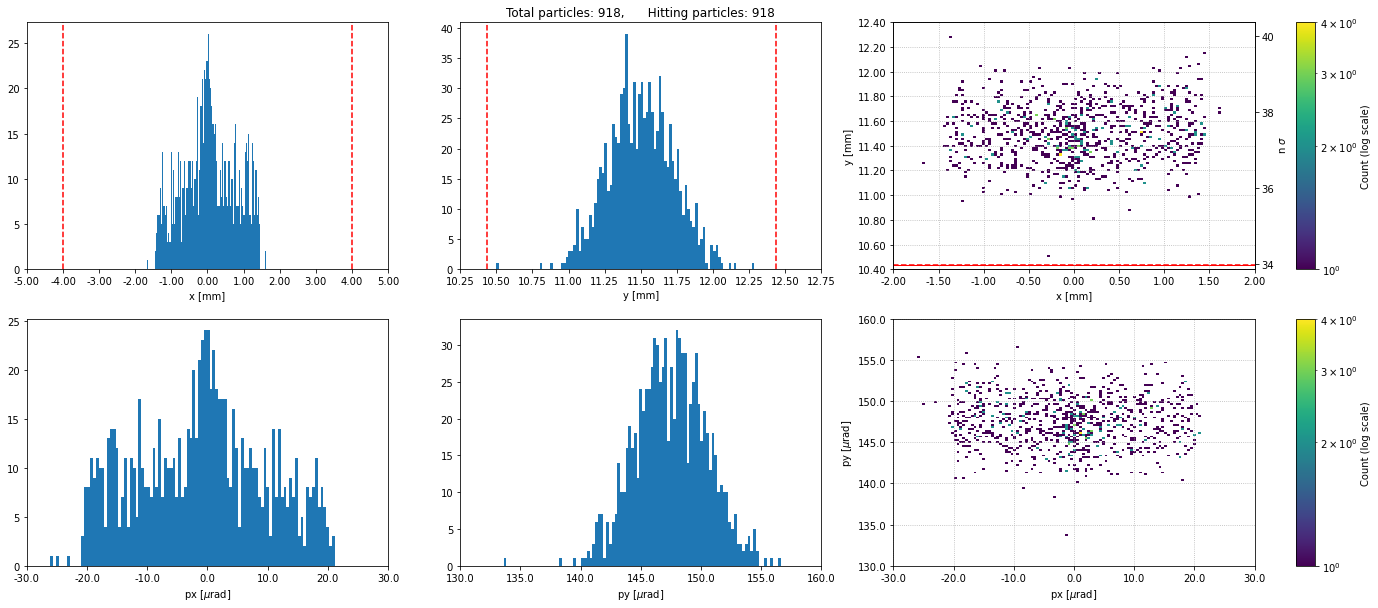

TCCS impacts:  5488 
inside critical angle: 1342 
TARGET impacts 918 
Common impacts:  918

IMPACTS ON TARGET FROM TCCS AT TURN  0


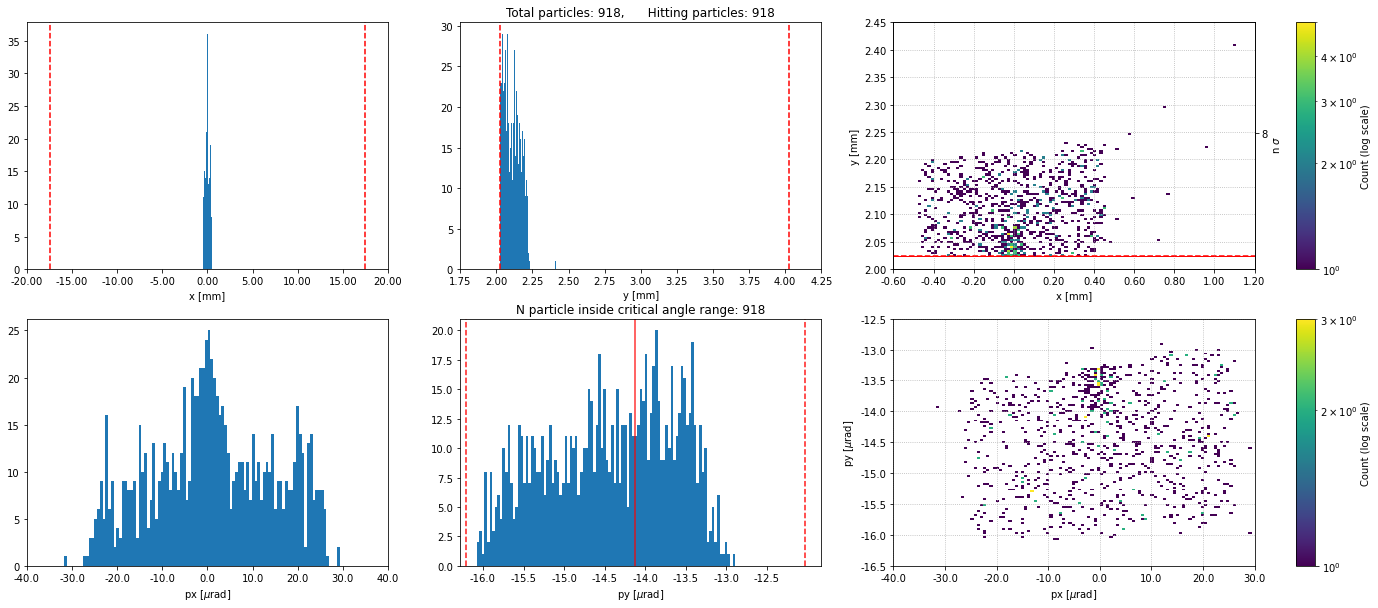

In [26]:
turn_plots(TCCS_tune, TARGET_tune, 0)

In [27]:
TCCS_tune.compute_channeled_part(TARGET_tune.impact_part)

n particles that hit TCCP inside critical angle range: 	 129733
n part inside critical angle range: 			 176993 		73.30%
n part that hit TCCS (multiple):			 289274 	44.85%
n part that hit TCCP: 					 129808 		99.94%
total n particle in simulation: 			 9.9e+06	1.31%


In [28]:
TCP_tune = TargetAnalysis(n_sigma=6.700000000000001, length=0.6, ydim=0.025, xdim=0.025, sigma=0.0003431239177650901)
PIXEL_tune = TargetAnalysis(n_sigma=33.6, length=0, ydim=0.01408, xdim=0.04246, sigma=0.00031074736684138284) 

In [29]:
TCP_tune.load_particles(as_before, df_key = 'TCP_generated')

!!! Succesful Jobs:  99 / 100  in file:  /eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_IR7_tune_very_new_version__target_absorber_20240312-0919


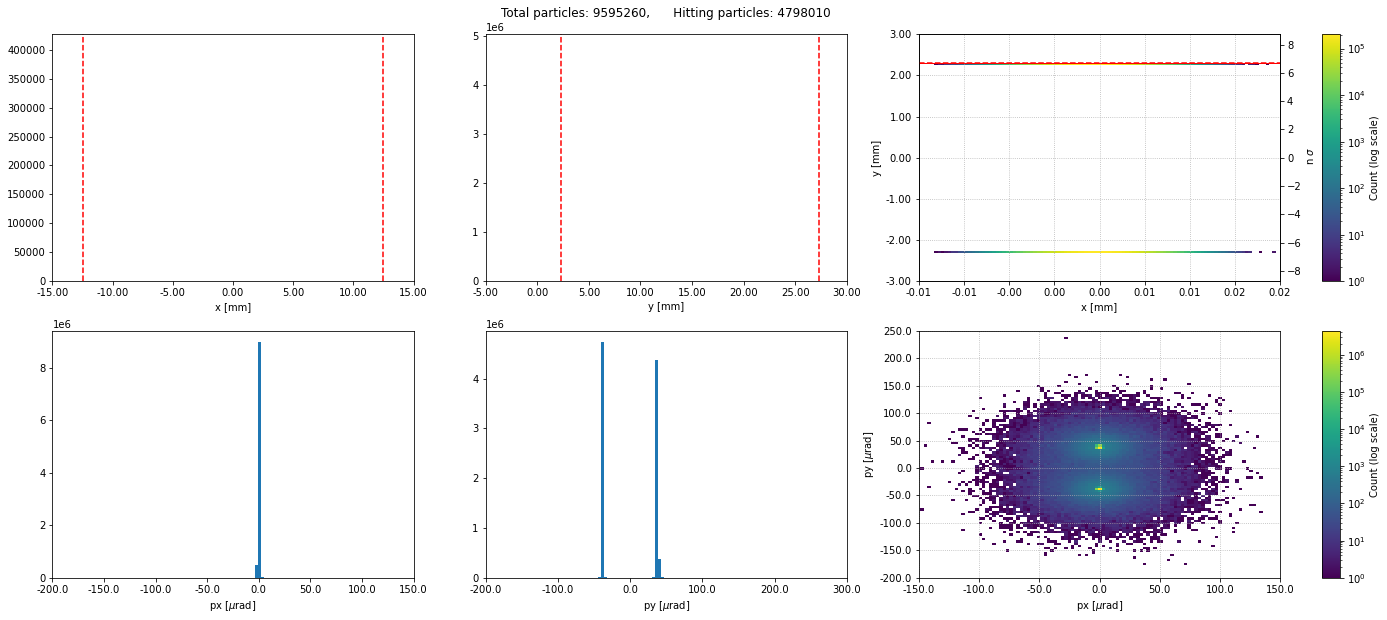

In [30]:
TCP_tune.compute_impact_particles()

In [31]:
TCP_tune.data

,zeta,x,px,y,py,delta,p0c,this_turn,particle_id,this_state,parent_particle_id,at_element,state,at_turn
0,-7.277856e-12,3.682476e-06,4.664867e-07,0.002300,0.000039,-1.151141e-06,7.000000e+12,0,0,1,0,0,1,200
1,3.493158e-12,5.962631e-06,-9.384527e-08,0.002300,0.000038,-1.903575e-07,7.000000e+12,0,1,1,1,36119,-331,25
2,-4.853337e-13,6.565127e-06,8.780966e-07,0.002300,0.000038,-1.707940e-06,7.000000e+12,0,2,1,2,36119,-331,14
3,-7.666355e-12,6.675061e-06,-1.295848e-06,0.002300,0.000039,-6.120484e-07,7.000000e+12,0,3,1,3,38718,-331,77
4,3.363663e-12,2.967152e-06,-8.574623e-07,0.002300,0.000038,-1.426793e-06,7.000000e+12,0,4,1,4,36119,-331,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96803,9.270390e-11,1.141206e-06,2.206737e-05,-0.002299,-0.000018,-2.302356e-06,7.000000e+12,0,9899995,1,9899995,37507,-331,0
96804,5.479449e-12,4.742088e-06,5.257876e-07,-0.002299,-0.000037,-2.075984e-06,7.000000e+12,0,9899996,1,9899996,36119,-331,14
96805,-6.323683e-12,1.521265e-06,-2.271616e-07,-0.002299,-0.000038,-1.294300e-06,7.000000e+12,0,9899997,1,9899997,36119,-331,11
96806,6.660375e-12,1.781721e-07,-1.093118e-07,-0.002298,-0.000037,-6.570384e-07,7.000000e+12,0,9899998,1,9899998,36119,-331,13


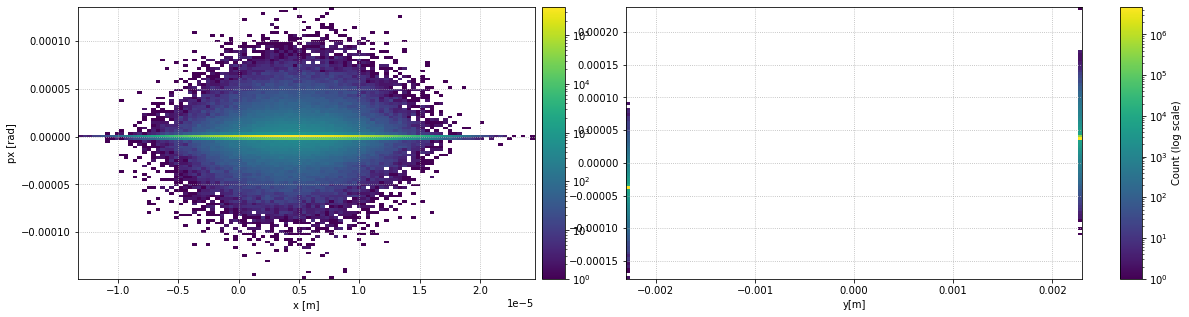

In [32]:
TCP_tune.plot_phasespace()

## Phase rematched

In [33]:
phase = 'TEST_IR7_tune_very_new_version_phase__target_absorber_20240312-0919'

In [34]:
get_analysis_init(phase, '_phase')

TCCS_phase = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.4112768973184399e-05, sigma=0.0002809246468332943)
TARGET_phase = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.008, sigma=0.00030701342643083826)
TCCP_phase = CrystalAnalysis(n_sigma=33.6, length=0.07, ydim=0.002, xdim=0.008, bending_radius=10.0, align_angle=0.00011145456439792997, sigma=0.00030703001184007424)
TCP_phase = TargetAnalysis(n_sigma=6.7, length=0.6, ydim=0.025, xdim=0.025, sigma=0.00034313098549789545)
PIXEL_phase = TargetAnalysis(n_sigma=33.6, length=0, ydim=0.01408, xdim=0.04246, sigma=0.000310581491878403)


In [35]:
TCCS_phase = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.4112768973184399e-05, sigma=0.0002809246468332943)
TARGET_phase = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.008, sigma=0.00030701342643083826)
TCP_phase = TargetAnalysis(n_sigma=6.7, length=0.6, ydim=0.025, xdim=0.025, sigma=0.00034313098549789545)

In [36]:
TCCS_phase.load_particles(phase, 'TCCS_impacts')

Delta angle -3.3299525454673517e-06


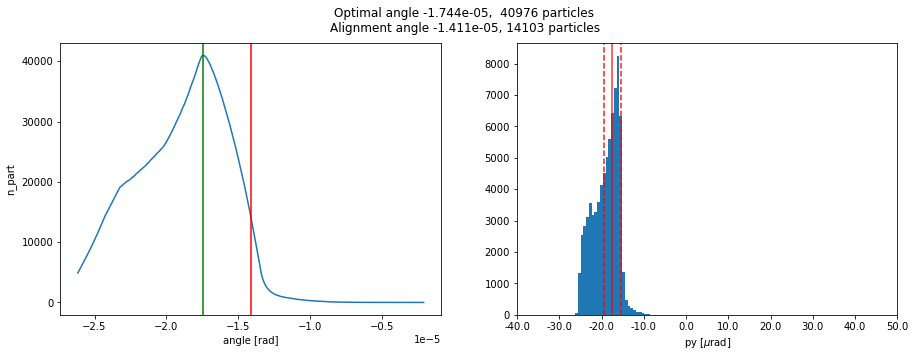

In [37]:
TCCS_phase.optimize_alignment()

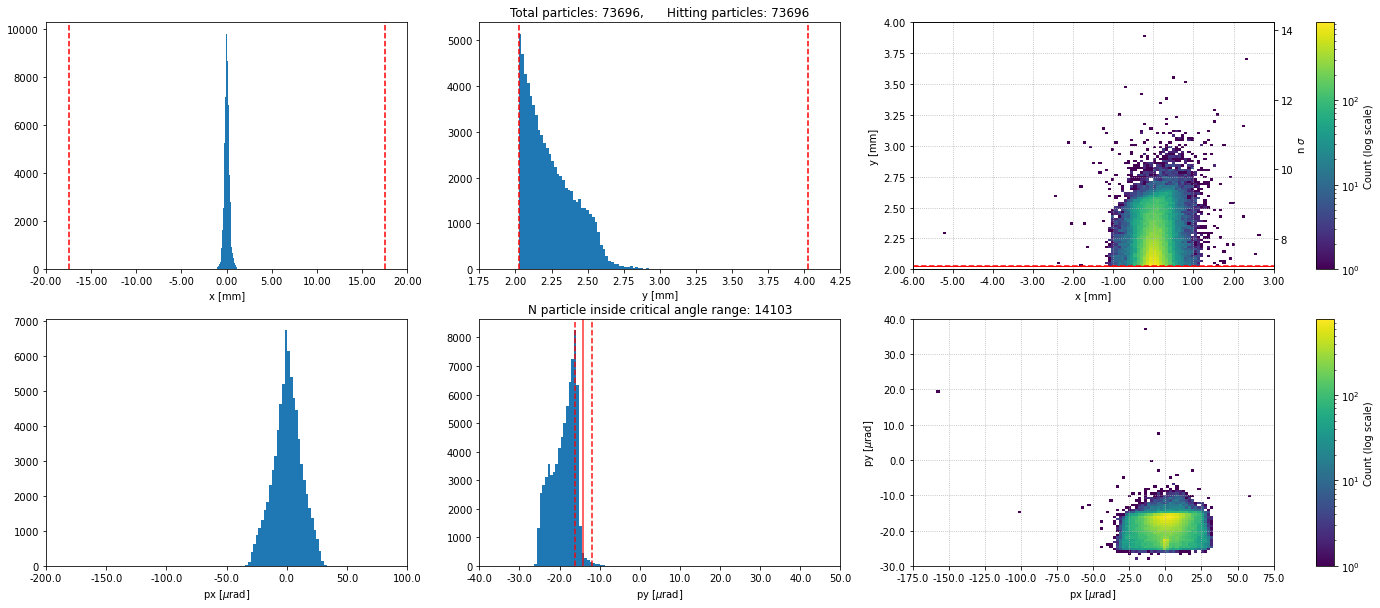

In [38]:
TCCS_phase.compute_impact_particles(xpcrit=True)

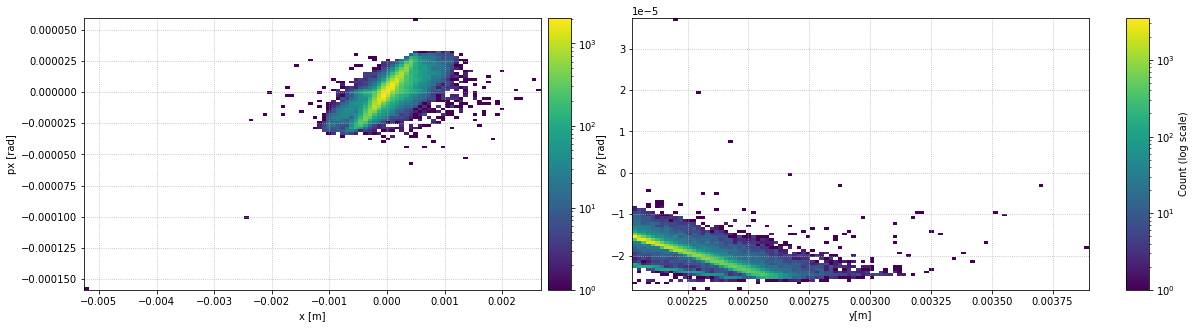

In [39]:
TCCS_phase.plot_phasespace()

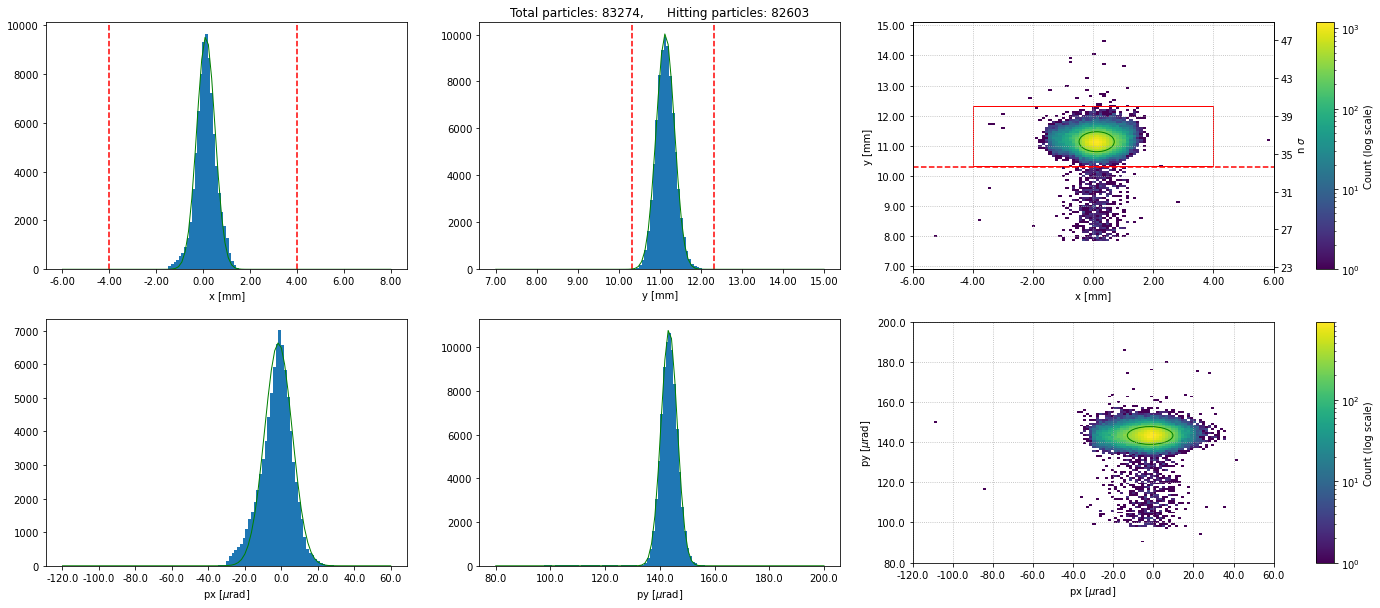

In [40]:
TARGET_phase.load_particles(phase, 'TARGET_impacts')
TARGET_phase.compute_impact_particles(fit=True) 

IMPACT ON TCCS AT TURN  0


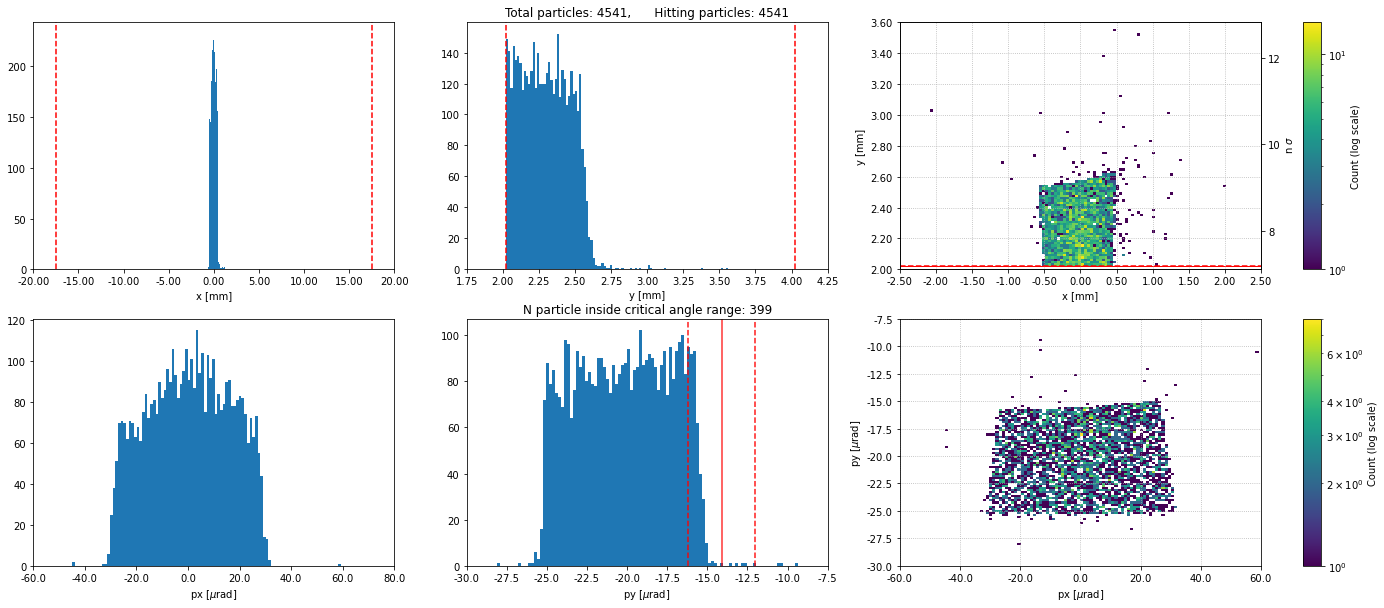

IMPACT ON TARGET AT TURN  0


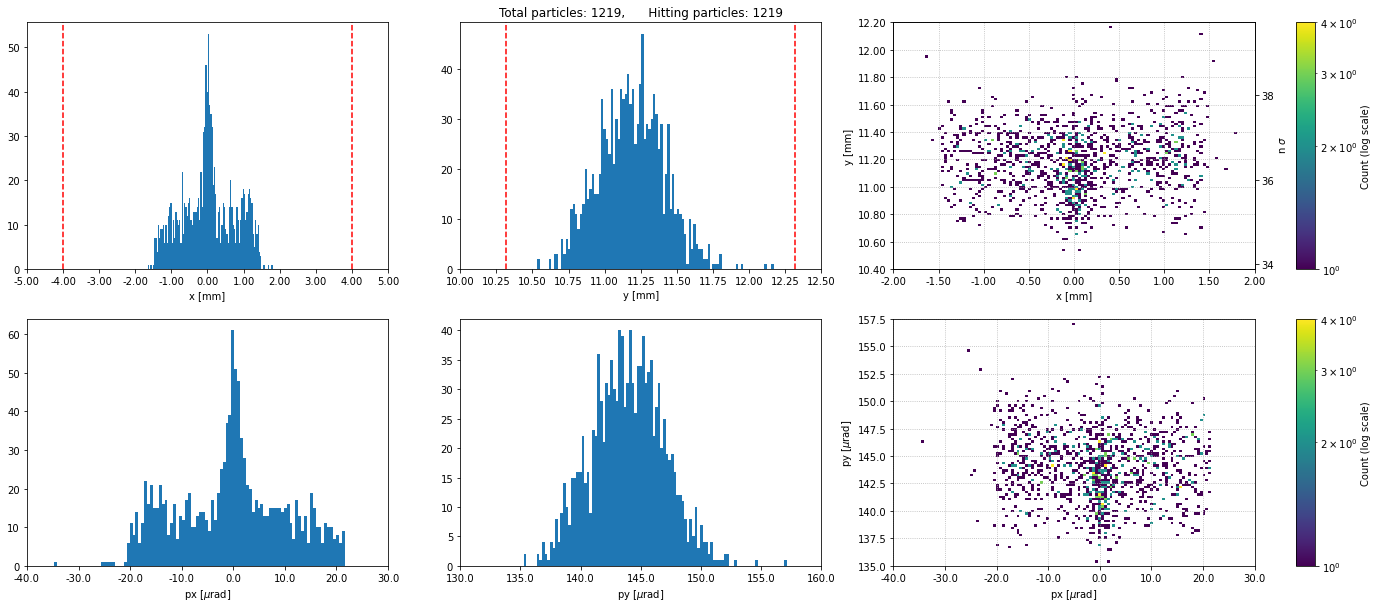

TCCS impacts:  4541 
inside critical angle: 399 
TARGET impacts 1219 
Common impacts:  150

IMPACTS ON TARGET FROM TCCS AT TURN  0


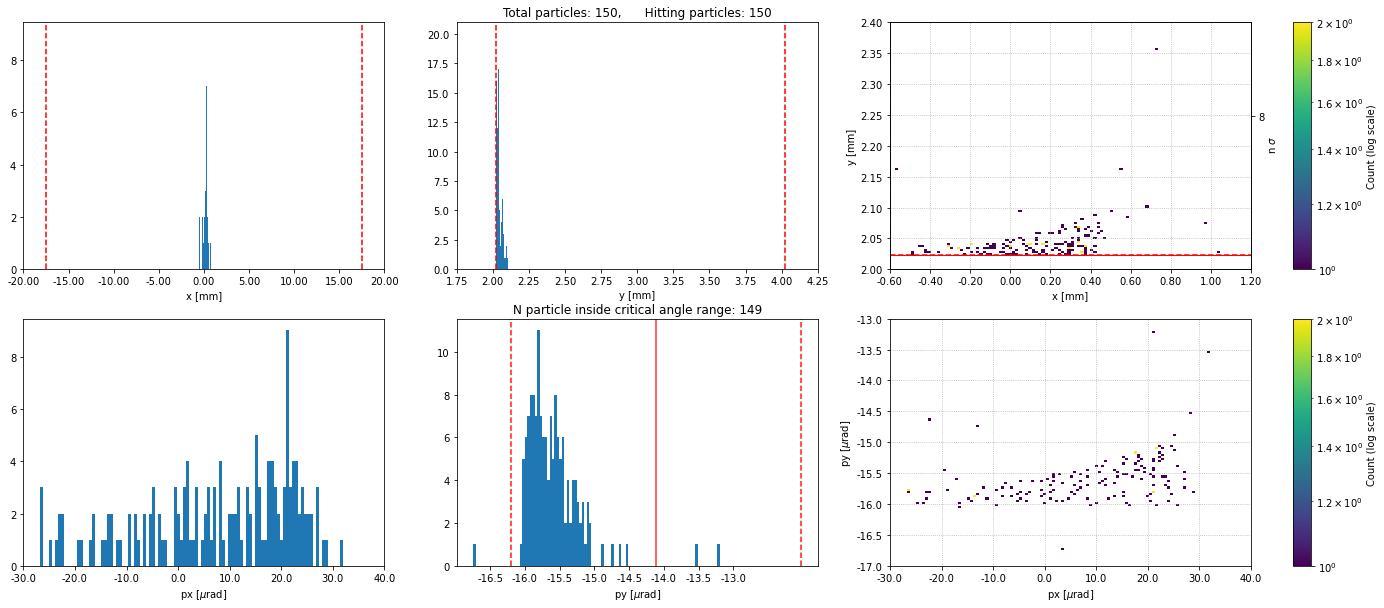

In [41]:
turn_plots(TCCS_phase, TARGET_phase, 0)

In [42]:
TCCS_phase.compute_channeled_part(TARGET_phase.impact_part)

n particles that hit TCCP inside critical angle range: 	 6646
n part inside critical angle range: 			 14103 		47.12%
n part that hit TCCS (multiple):			 73696 	9.02%
n part that hit TCCP: 					 82603 		8.05%
total n particle in simulation: 			 1.0e+07	0.07%


In [43]:
TCP_phase.load_particles(phase, df_key = 'TCP_generated')

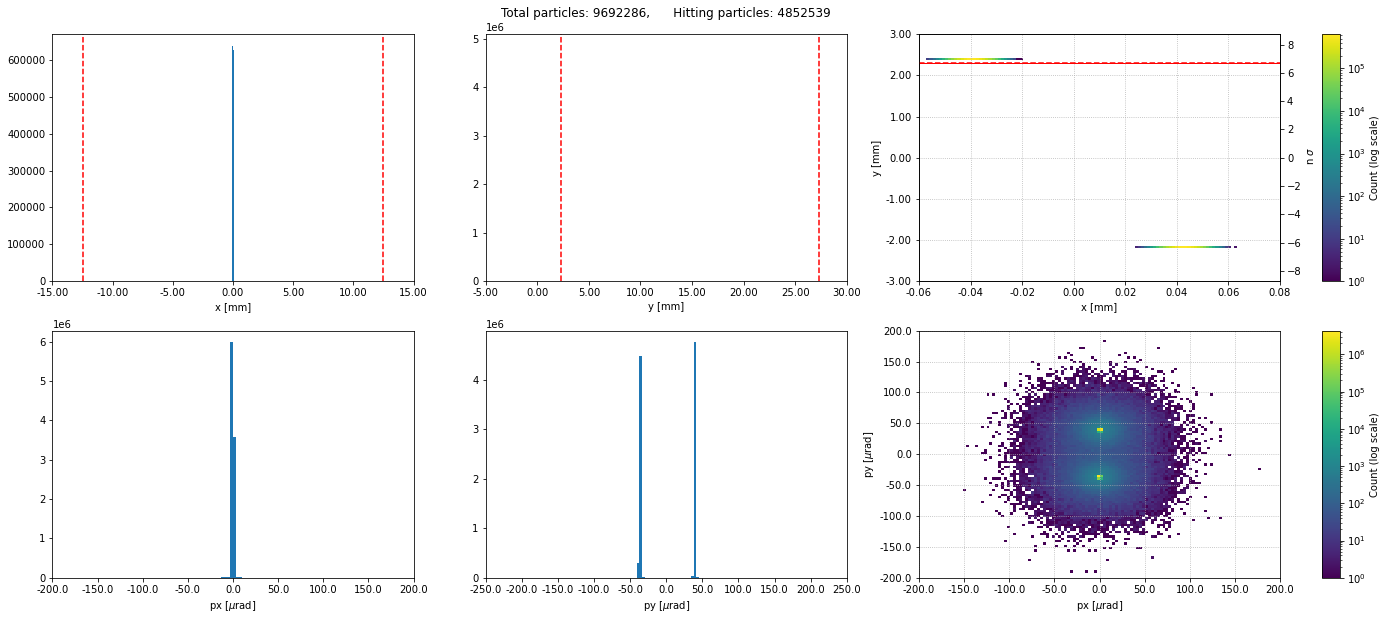

In [44]:
TCP_phase.compute_impact_particles()

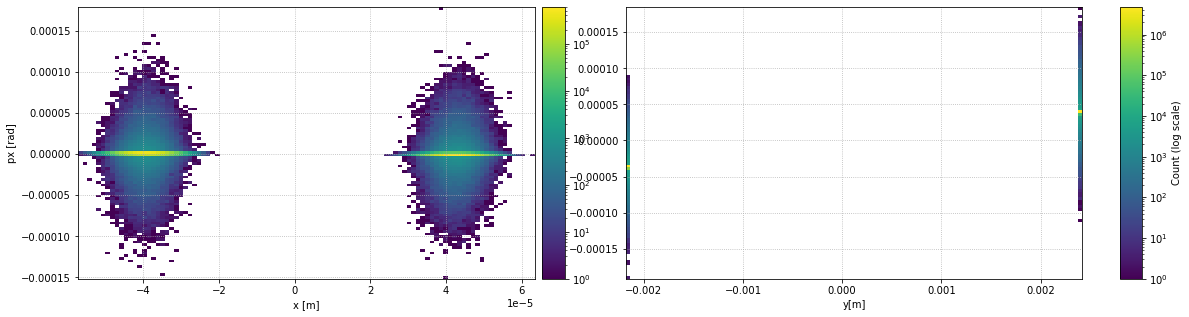

In [ ]:
TCP_phase.plot_phasespace()

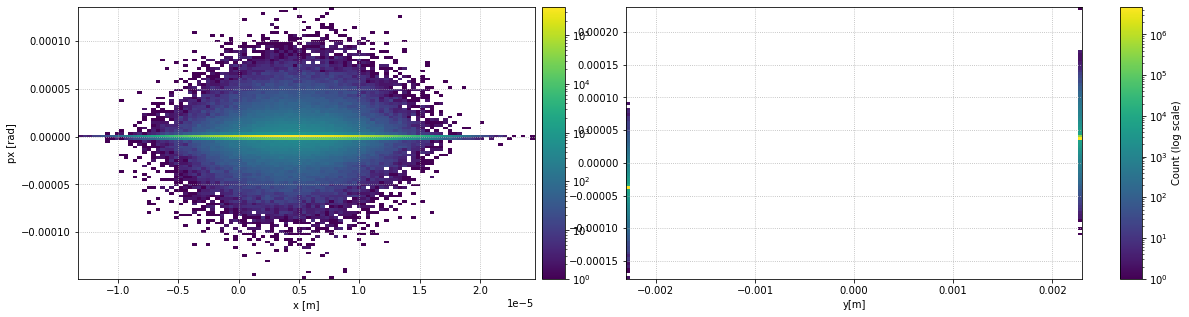

In [ ]:
TCP_tune.plot_phasespace()


13


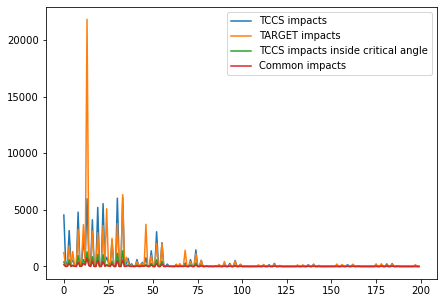

In [ ]:
plot_turns(TCCS_phase, TARGET_phase)

13


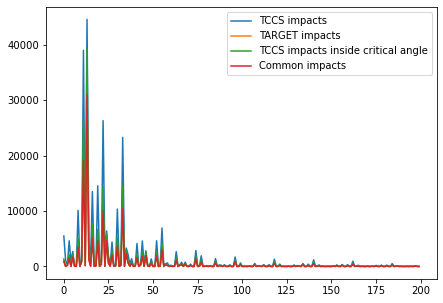

In [ ]:
plot_turns(TCCS_tune, TARGET_tune)

IMPACT ON TCCS AT TURN  0


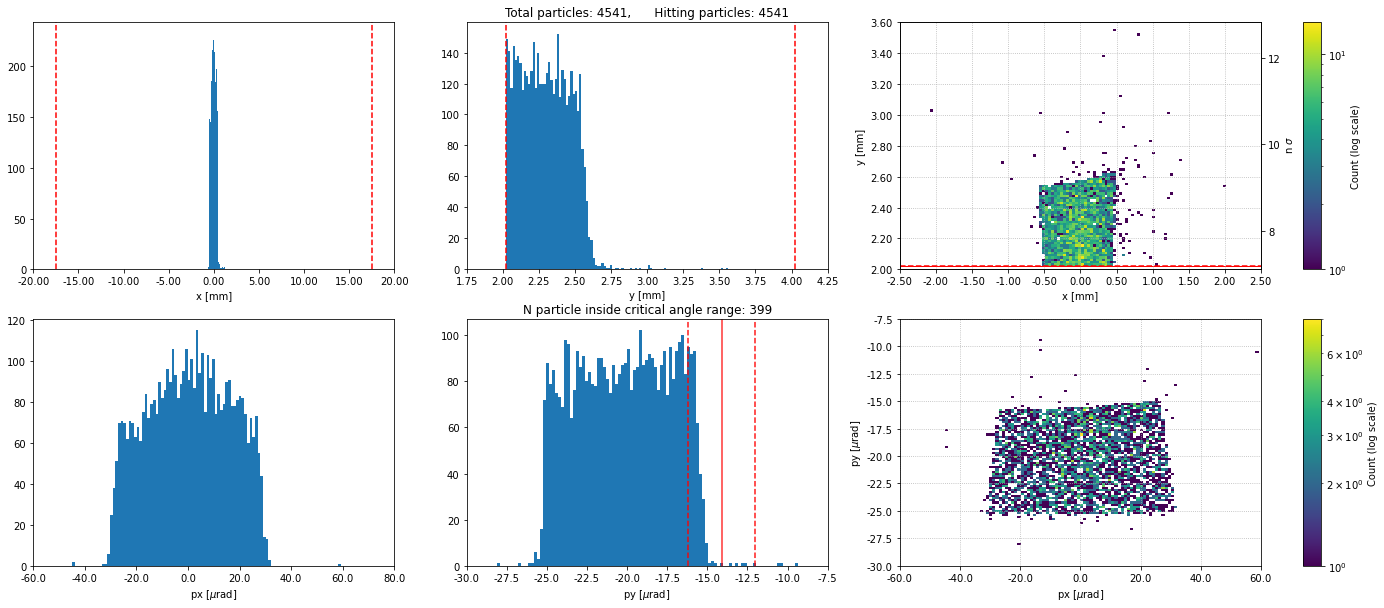

IMPACT ON TARGET AT TURN  0


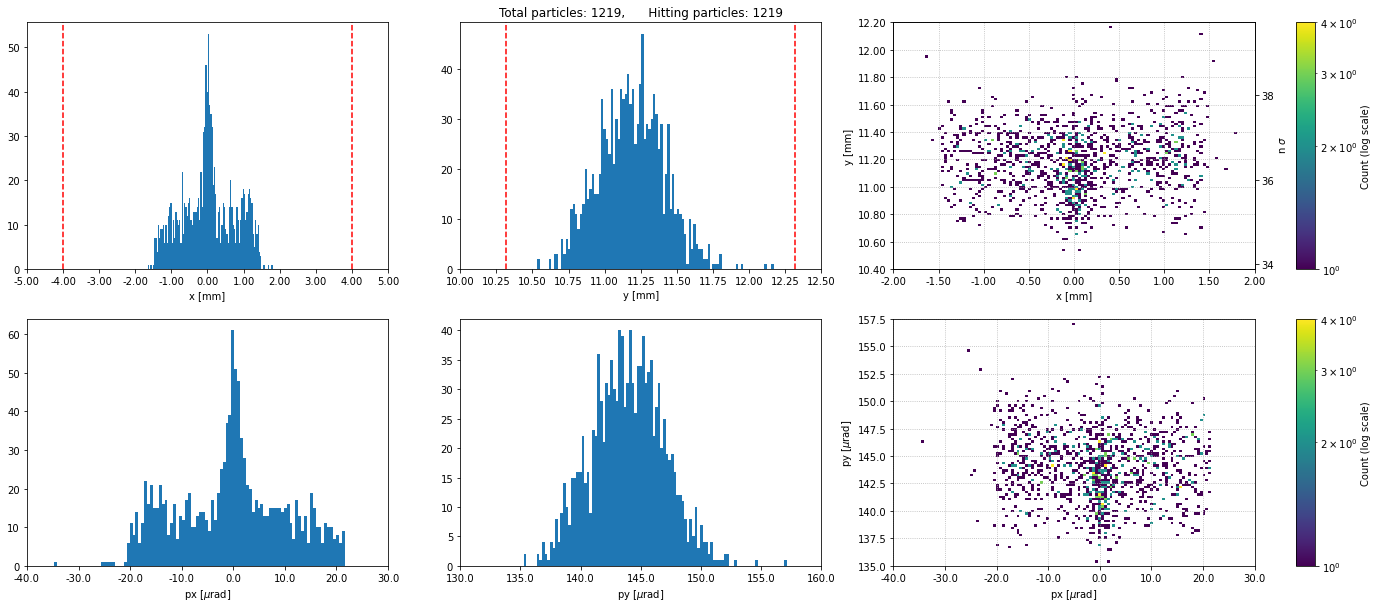

TCCS impacts:  4541 
inside critical angle: 399 
TARGET impacts 1219 
Common impacts:  150

IMPACTS ON TARGET FROM TCCS AT TURN  0


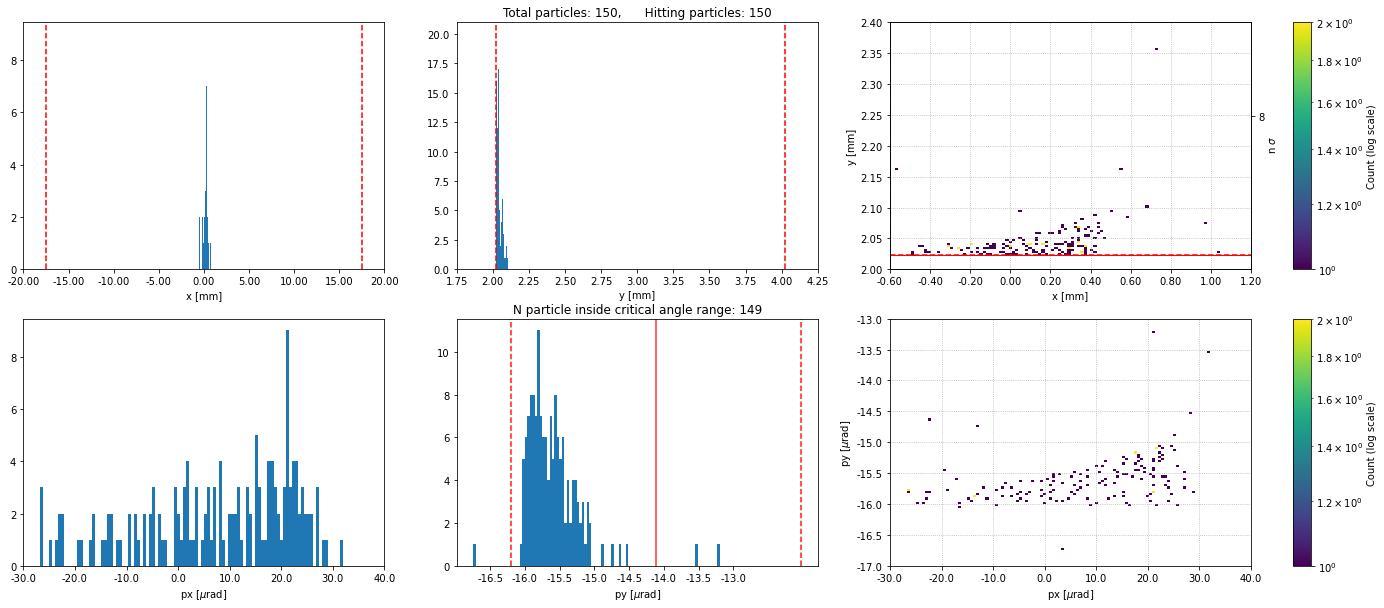

In [ ]:
turn_plots(TCCS_phase, TARGET_phase, 0)


Delta angle -1.1887686184543034e-06


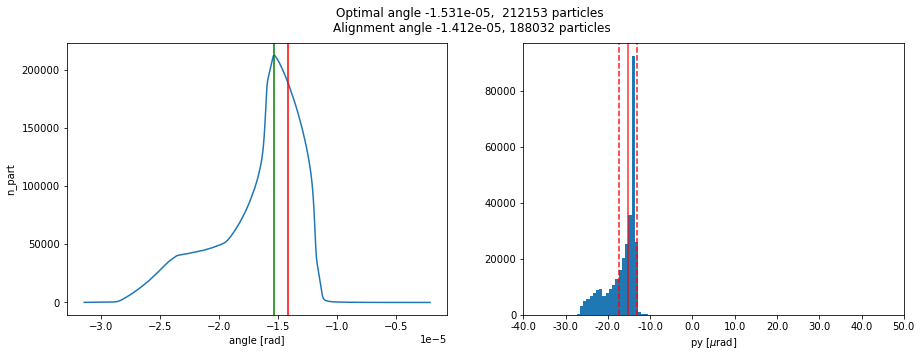

In [ ]:
IR7rem_TCCS_7_2 = 'TEST_IR7_rem_TCCS_7.2__target_absorber_20240220-0926'
TCCS_IR7_7_2 = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.4117809785569858e-05, sigma=0.0020239975348699253/7.2)
TCCS_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TCCS_IR7_7_2.optimize_alignment()


In [ ]:
TARGET_IR7_7_2 = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, sigma=0.010321720186418094/33.6)
TARGET_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TARGET_impacts") 

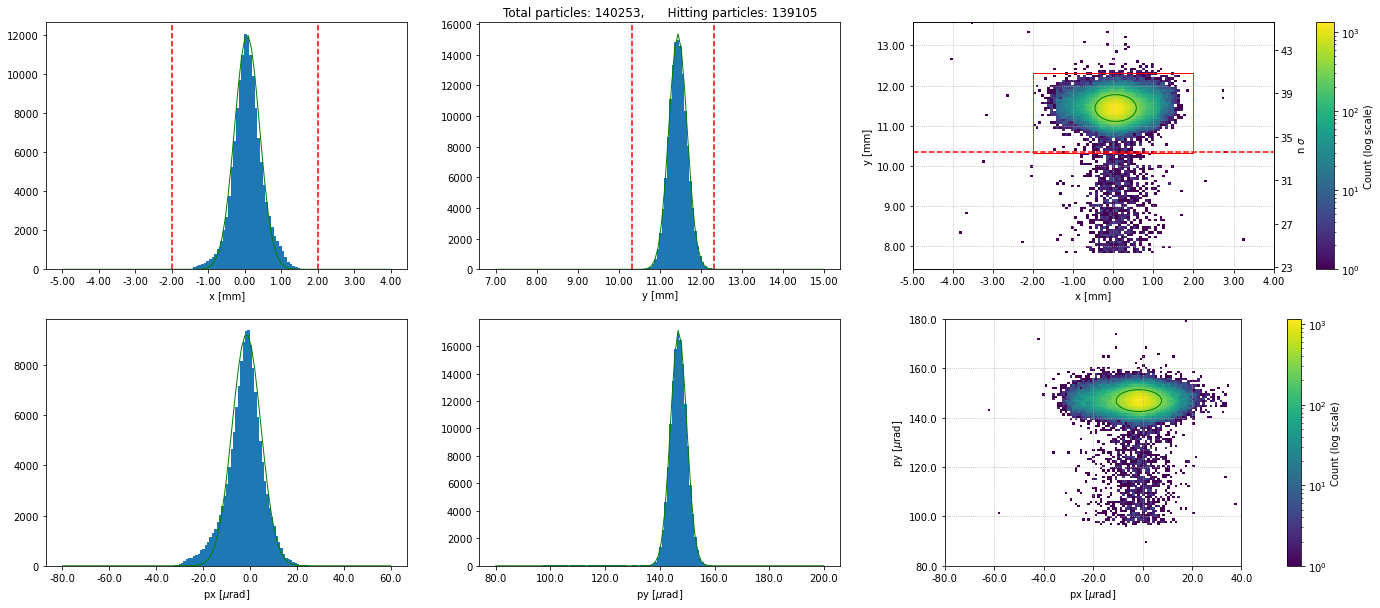

In [ ]:
TARGET_IR7_7_2.compute_impact_particles(fit=True)

Delta angle -6.007524368711116e-09


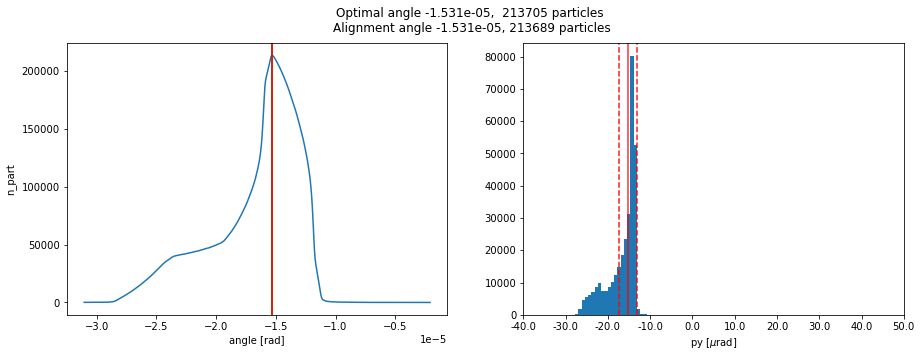

In [ ]:
IR7rem_TCCS_7_2_angle = 'TEST_IR7rem_TCCS_7.2__target_absorber_20240223-1620'
TCCS_IR7_7_2_angle  = CrystalAnalysis(n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bending_radius=80.0, align_angle=-1.5306578399325507e-05, sigma=0.00028111076872336534)
TCCS_IR7_7_2_angle.load_particles(IR7rem_TCCS_7_2_angle, df_key="TCCS_impacts")
TCCS_IR7_7_2_angle.optimize_alignment()

In [ ]:
TARGET_IR7_7_2_angle = TargetAnalysis(n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, sigma=0.00030719405326038677)
TARGET_IR7_7_2_angle.load_particles(IR7rem_TCCS_7_2_angle, df_key="TARGET_impacts") 

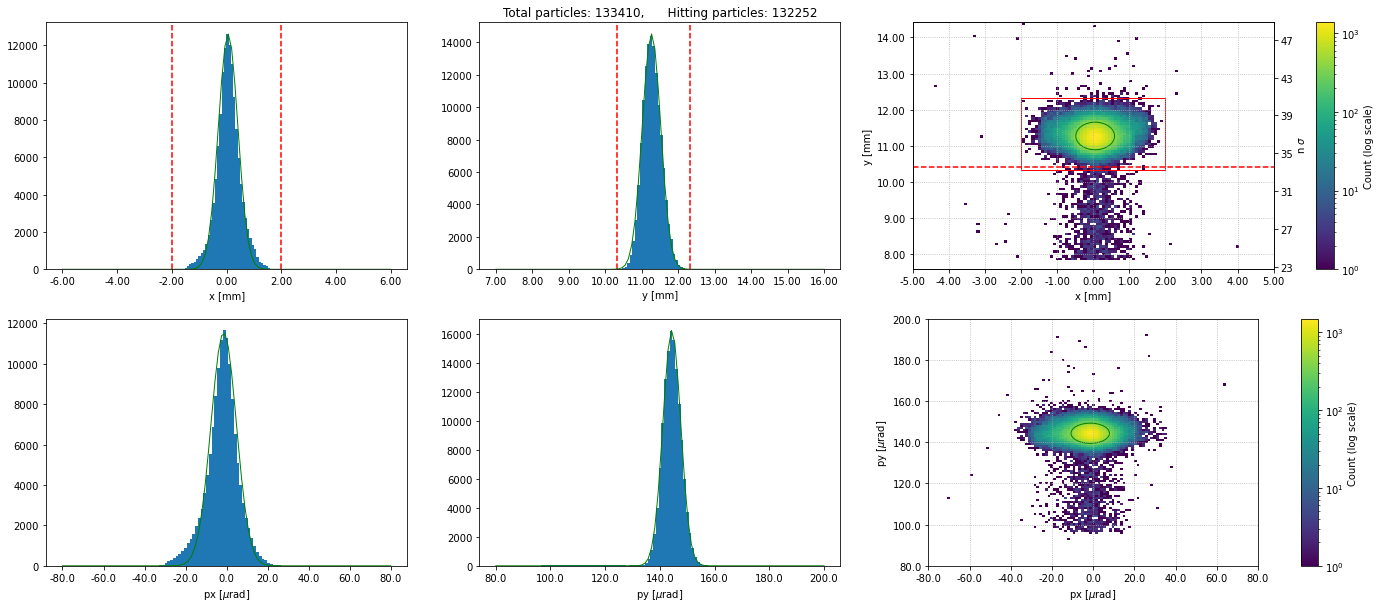

In [ ]:
TARGET_IR7_7_2_angle.compute_impact_particles(fit=True)

In [ ]:
TARGET_IR7_7_2.fit

,mu,sigma,A
x,0.000062,0.000343,5947.848153
y,0.011440,0.000222,4974.819381
px,-0.000002,0.000006,6433.353989
py,0.000147,0.000003,7389.998929


In [ ]:
TARGET_IR7_7_2_angle.fit

,mu,sigma,A
x,0.000056,0.000357,5311.849052
y,0.011271,0.000255,4141.973205
px,-0.000001,0.000006,7542.303541
py,0.000144,0.000003,5617.138307


In [ ]:
0.011271-0.011440

-0.00016900000000000075

In [ ]:

TARGET_IR7_7_2_angle.abs_y_low = TARGET_IR7_7_2_angle.abs_y_low  - 0.00016900000000000075/4
TARGET_IR7_7_2_angle.abs_y_up = TARGET_IR7_7_2_angle.abs_y_low  - 0.00016900000000000075/4 + TARGET_IR7_7_2_angle.ydim



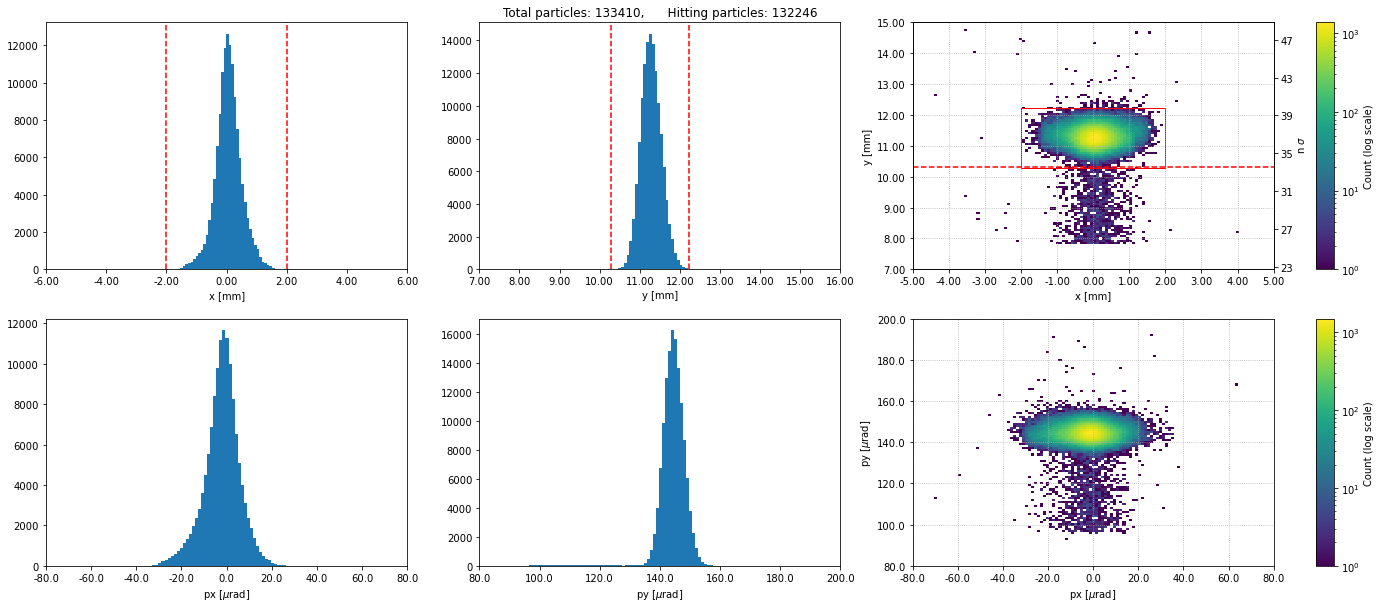

In [ ]:
TARGET_IR7_7_2_angle.compute_impact_particles()

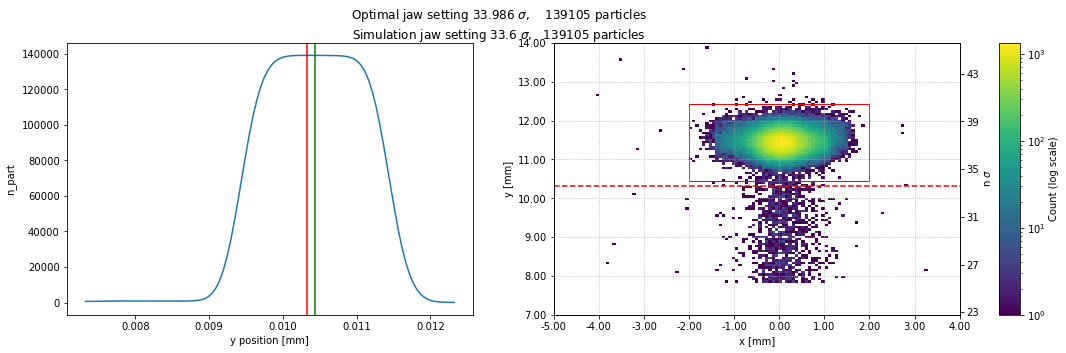

In [ ]:
TARGET_IR7_7_2.optimize_POT()

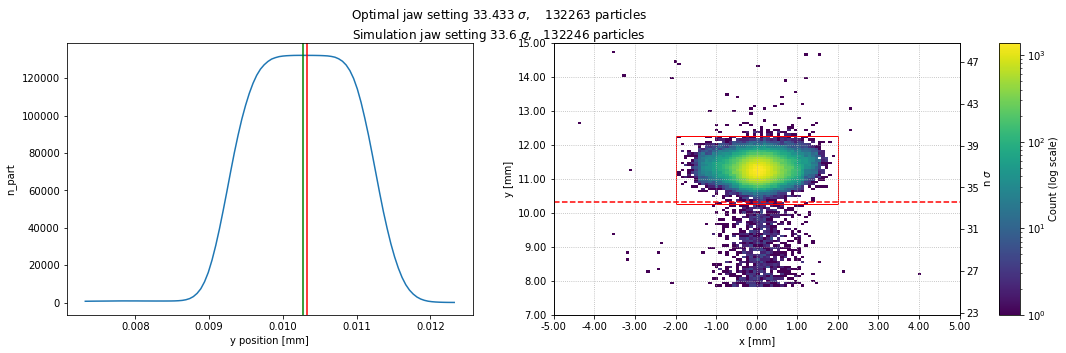

In [ ]:
TARGET_IR7_7_2_angle.optimize_POT()

Maximum inefficiency in the DS is 4.68e-06.


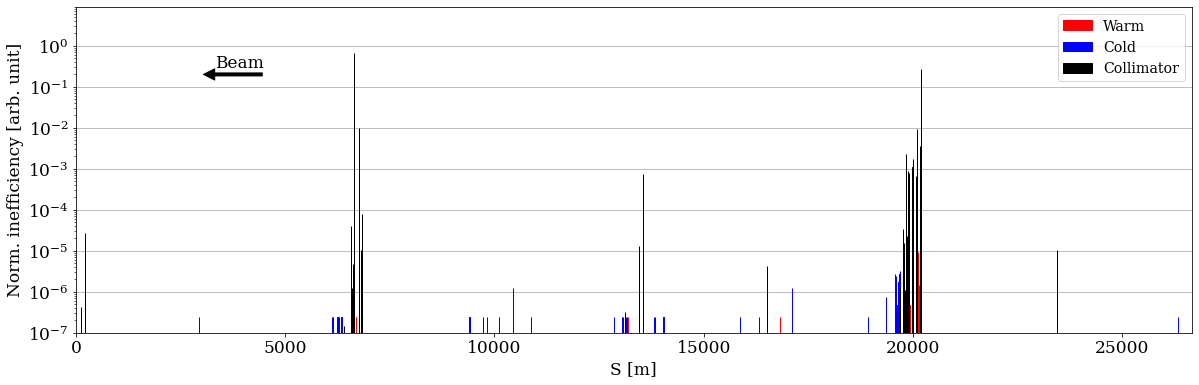

In [ ]:
IR7_v2 = 'TEST_IR7rem_TCCS_7.2__target_absorber_20240228-1035'
TARGET_IR7_7_2.load_lossmap(IR7_v2, plot = True, zoom=False)

Maximum inefficiency in the DS is 4.91e-06.
pymadx.Tfs.Load> normal file


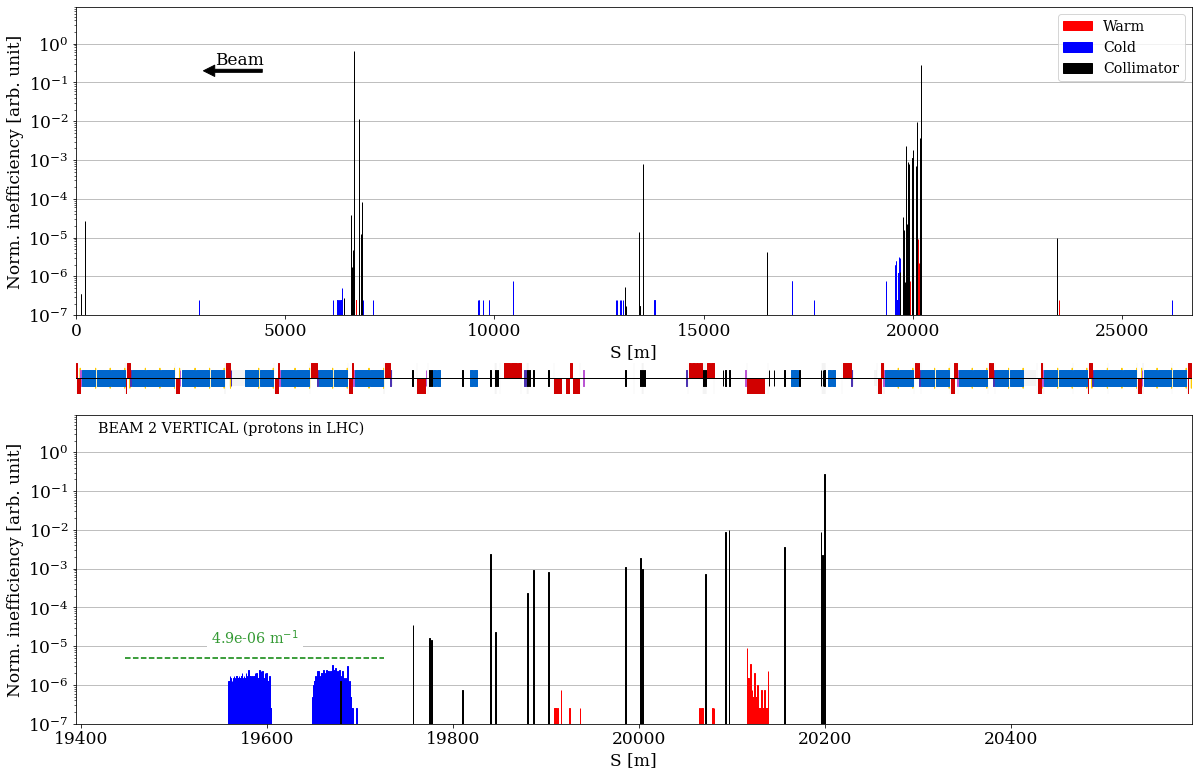

In [ ]:
TARGET_IR7_7_2_angle.load_lossmap(IR7rem_TCCS_7_2_angle, plot = True)

In [ ]:
TARGET_IR7_7_2_angle.data

,zeta,x,px,y,py,delta,p0c,this_turn,particle_id,this_state,parent_particle_id,at_element,state,at_turn
0,0.003039,0.000656,-9.501613e-06,0.010933,0.000140,-0.000002,7.000000e+12,89,37,1,37,110984,-340,89
1,0.003585,-0.000062,-1.801358e-06,0.011381,0.000146,-0.000027,7.000000e+12,61,124,1,124,110984,-340,61
2,0.001162,0.000148,-1.820746e-06,0.010910,0.000139,-0.000012,7.000000e+12,30,170,1,170,110984,-340,30
3,0.004201,0.000311,-6.329647e-06,0.011253,0.000144,-0.000024,7.000000e+12,114,176,1,176,110984,-340,114
4,0.001149,0.000012,-2.150021e-07,0.011002,0.000141,-0.000011,7.000000e+12,27,585,1,585,110984,-340,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,0.004902,-0.000821,1.664559e-05,0.011247,0.000144,-0.000080,7.000000e+12,44,9999646,1,9999646,110984,-340,44
1309,0.000943,-0.000007,-6.871895e-07,0.011246,0.000144,-0.000010,7.000000e+12,25,9999846,1,9999846,110984,-340,25
1310,0.006839,0.000513,-1.217283e-05,0.011017,0.000141,-0.000027,7.000000e+12,91,9999914,1,9999914,110984,-340,91
1311,0.003084,-0.000520,8.072193e-06,0.010846,0.000139,-0.000050,7.000000e+12,19,9999945,1,9999945,110984,-340,19


In [ ]:
np.max(np.abs(TARGET_IR7_7_2_angle.data['delta']))

0.100568466

In [ ]:
np.max(TARGET_IR7_7_2_angle.data['delta'])

3.6587696e-06

In [ ]:
np.min(TARGET_IR7_7_2_angle.data['delta'])

-0.100568466

In [ ]:
print(7e12*(1-0.00008))

6999440000000.0


In [ ]:
pc = 4e11*(1-0.0)

pot_crit = 21.34 #16 #eV Silicon
en_crit = 5.7e9 / 1e-2 
bending_radius=80.0

xp_crit0 = np.sqrt(2.0*pot_crit/pc)
Rcrit = pc/en_crit
    
    #print(f'xp_crit0: {xp_crit0}, Rcrit: {Rcrit}')

xp_crit = xp_crit0*(1-Rcrit/bending_radius)
print(xp_crit)

1.0238958950692563e-05


In [ ]:
pc = 4e11*(1-0.001)

pot_crit = 21.34 #16 #eV Silicon
en_crit = 5.7e9 / 1e-2 
bending_radius=80.0

xp_crit0 = np.sqrt(2.0*pot_crit/pc)
Rcrit = pc/en_crit
    
    #print(f'xp_crit0: {xp_crit0}, Rcrit: {Rcrit}')

xp_crit = xp_crit0*(1-Rcrit/bending_radius)
print(xp_crit)

1.024417292857533e-05


In [ ]:
TCCS_phase.align_angle


-1.4112768973184399e-05

In [ ]:
TCCS_tune.align_angle

-1.4117913840472246e-05